# Golman and Bhatia (2017), A Cognitive Model of Strategic Deliberation and Decision Making

Abstract:

We study game theoretic decision making using a
bidirectional evidence accumulation model. Our model
represents both preferences for the strategies available to the
decision maker, as well as beliefs regarding the opponent’s
choices. Through sequential sampling and accumulation, the
model is able to intelligently reason through two-player
strategic games, while also generating specific violations of
Nash equilibrium typically observed in these games. The
main ingredients of accumulator models, stochastic sampling
and dynamic accumulation, play a critical role in explaining
these behavioral patterns as well as generating novel
predictions

**This is a partial replication of Golman and Bhatia. I have not yet attempted to reproduce their results for the hi-lo game or the boobytrap game.**

In [1]:
import numpy as np
from math import e
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from itertools import product

%matplotlib inline

The model has a layer of nodes for the player/decision maker's strategies, and a layer for the opponent's strategies. The model iteratively updates each layer's activations. The below steps illustrate how the player's layer is updated based on the opponent's layer.

1. Sample/select a strategy from the opponent's layer, according to the activations and a parameter governing the stochasticity/determinism of the selection process.
2. For each strategy, find the utilties the player would get if the opponent played the strategy selected in (1).
3. Add the utilities from (2) to the player's current activations

A similar process then updates the opponent layer based on the player's layer.

Below is a schematic of the model:

![](bidirectional_accumulation_model.png)

In [2]:
def simulate_decision(strats=list(range(20,100,10)), T=10, payoff_func=None, _lambda=1, 
                      sigmas=0, gamma=11):
    """
    strats: list-like of elements which payoff_func can take.

    T: integer, number of times to update both player and opponent strategy activations
    
    payoff_func: function taking player_strategy, opponent_strategy, for traveler's dilemma,
    must also specify gamma, a reward/penalty parameter.
    
    `_lambda`: float. _lambda is a 'stochasticity parameter'. If it's 0, strategies are sampled 
    from a uniform distribution despite their activations. If `_lambda` is very high, the most 
    active strategy is always chosen.

    `_sigma`: list-like of floats or ints governing the salience (bias) of different strategies.
            or 0.
    """
    if sigmas == 0:
        sigmas = np.zeros(len(strats))
    
    player_strategy_activations   = np.zeros(len(strats))
    opponent_strategy_activations = np.zeros(len(strats))
    
    for t in range(T):
        for strat_acts in [opponent_strategy_activations, player_strategy_activations]:
            num = e**(_lambda*(strat_acts + sigmas))
            dist_over_strats = num / num.sum()
            sampled_strat = np.random.choice(a=strats, p=dist_over_strats)

            player_utilities = [payoff_func(player_strat=x,
                                            opponent_strat=sampled_strat,
                                            gamma=gamma) for x in strats]
            strat_acts += player_utilities

    decision = strats[np.argmax(player_strategy_activations)]
    return decision

# Traveler's Dilemma

In the traveler's dilemma, two travelers have lost identical items and must request compensation from an airline. The airline, wishing to disincentive outrageously high claims, will accept the lower claim as valid, and pay that amount to both travelers. However, the traveler that submitted the lower claim gets a reward of size `gamma`, while the traveler that submitted the higher claim gets a penalty of equal size.

In [3]:
def travelers_dillema_payoffs(player_strat, opponent_strat, gamma):
    """
    returns only the player_payoff
    """
    if player_strat > opponent_strat:
        return 0.01*(opponent_strat - gamma)
    elif player_strat == opponent_strat:
        return 0.01*player_strat
    else:
        return 0.01*(player_strat + gamma)

In [6]:
Ts       = [10, 20, 30]
_lambdas = [.25, .5, 1, 2, 4]
gammas   = [11, 19]

sim_count = 3000

This next cell takes about 5 minutes -- there are 30 combinations of the above parameter settings, so the below will need to execute 30 loops, each of which runs `sim_count` (usually 3000) simulations.

In [7]:
parameter_sweep_results = []
for T, _lambda, gamma in tqdm(product(Ts, _lambdas, gammas)):
    for _ in range(sim_count):
        strategy = simulate_decision(payoff_func=travelers_dillema_payoffs, T=T, 
                                     _lambda=_lambda, gamma=gamma)
        parameter_sweep_results.append([T, _lambda, gamma, strategy])
        
parameter_sweep_results = pd.DataFrame(data=parameter_sweep_results, columns=['T', 'lambda', 'gamma', 'strategy'])

30it [04:53,  9.79s/it]


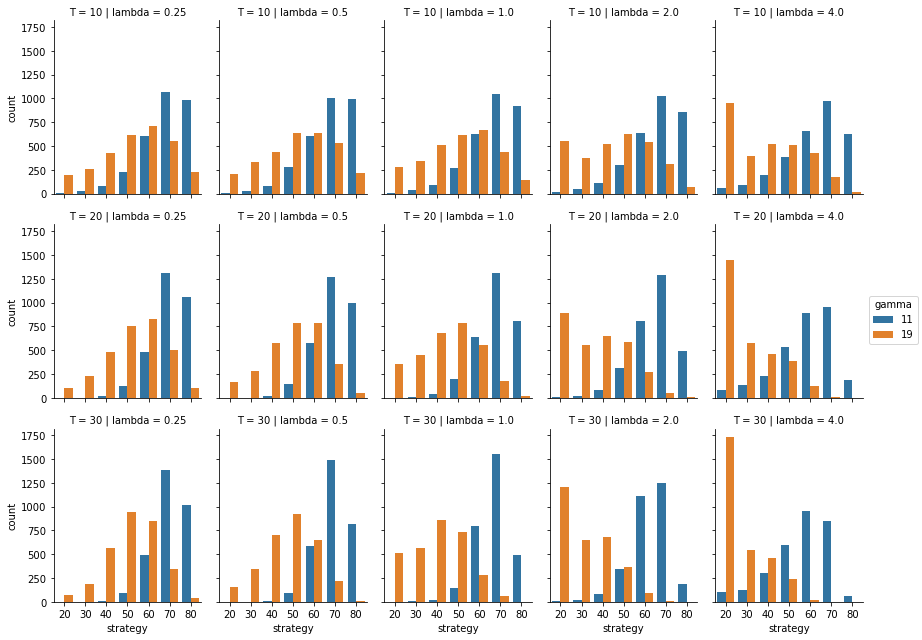

In [14]:
sns.factorplot(x="strategy", col="lambda", row="T", hue="gamma", 
               data=parameter_sweep_results, kind="count", size=3, aspect=.8);

The Nash equilibrium for the Traveler's Dilemma is to submit the lowest possible claim, here 20. In practice people don't do this, typically selecting much higher claims. The above plot shows that, across a wide array of parameter settings, the present model also fails to 'unravel'; that is, the model usually selects a much higher strategy.